# Logistic Regression

This function shows how to use TensorFlow to solve logistic regression.
$ \textbf{y} = sigmoid(\textbf{A}\times \textbf{x} + \textbf{b})$

We will use the low birth weight data, specifically:
```
#  y = 0 or 1 = low birth weight
#  x = demographic and medical history data
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import requests
from tensorflow.python.framework import ops
import os.path
import csv

In [2]:
ops.reset_default_graph()

# Create graph
sess = tf.Session()

## Obtain and prepare data for modeling

In [13]:
# name of data file
birth_weight_file = 'birth_weight.csv'

# download data and create data file if file does not exist in current directory
if not os.path.exists(birth_weight_file):
    
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/' + \
    'raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1] for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        f.close()

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
     csv_reader = csv.reader(csvfile)
     birth_header = next(csv_reader)
     for row in csv_reader:
         birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

# Pull out target variable
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[1:8] for x in birth_data])

# set for reproducible results
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# Normalize by column (min-max norm)
def normalize_cols(m, col_min=np.array([None]), col_max=np.array([None])):
    if not col_min[0]:
        col_min = m.min(axis=0)
    if not col_max[0]:
        col_max = m.max(axis=0)
    return (m-col_min) / (col_max - col_min), col_min, col_max
    
x_vals_train, train_min, train_max = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test, _, _ = np.nan_to_num(normalize_cols(x_vals_test, train_min, train_max))

## Define Tensorflow computational graph

In [14]:
# Declare batch size
batch_size = 25

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[7,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

## Train model

In [15]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i+1)%300==0:
        print('Loss = ' + str(temp_loss))
        

Loss = 0.64783365
Loss = 0.60129446
Loss = 0.63837355
Loss = 0.615863
Loss = 0.561395


## Display model performance

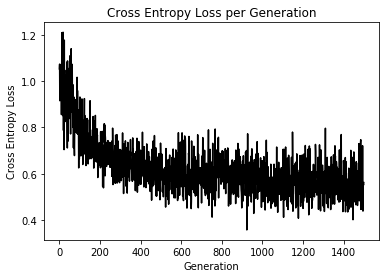

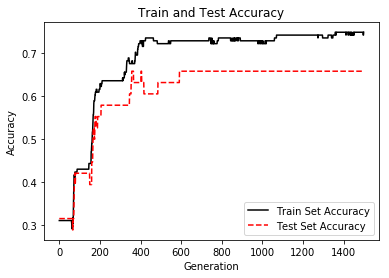

In [16]:
%matplotlib inline
# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()